In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

Using TensorFlow backend.


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6348802012138025898
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 861275013253878498
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 15692118166976803587
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 10915282944
locality {
  bus_id: 1
  links {
  }
}
incarnation: 3555793041144724486
physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:05:00.0, compute capability: 6.1"
]


In [2]:
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

In [3]:
head = ['HK Time', 'Open', 'High', 'Low', 'Close', 'Volume']
data_2017 = pd.read_csv("OUT_DAT_ASCII_AUDJPY_M1_2017.csv", delimiter=";", 
                        names=head)
data_2018 = pd.read_csv("OUT_DAT_ASCII_AUDJPY_M1_2018.csv", delimiter=";",
                        names=head)
data_2019 = pd.read_csv("OUT_DAT_ASCII_AUDJPY_M1_201901.csv", delimiter=";",
                        names=head)
train_data = data_2017.append(data_2018, ignore_index=True)
train_data = train_data['Close'].values.astype('float32')
data_2019 = data_2019['Close'].values.astype('float32')

import copy
train_data_unscale = copy.deepcopy(train_data)
data_2019_unscale = copy.deepcopy(data_2019)

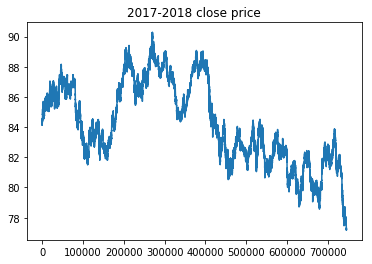

In [4]:
plt.plot(train_data)
plt.title("2017-2018 close price")
plt.show()

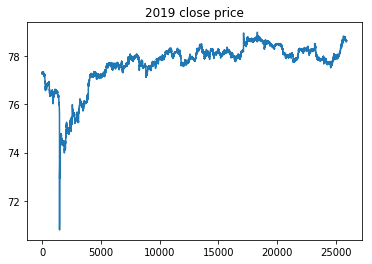

In [5]:
plt.plot(data_2019)
plt.title("2019 close price")
plt.show()


In [6]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaler2 = MinMaxScaler(feature_range=(0, 1))
train_data = scaler.fit_transform(train_data.reshape(len(train_data), -1))
data_2019 = scaler2.fit_transform(data_2019.reshape(len(data_2019), -1))


In [7]:
def create_dataset(dataset, look_back=1):
    data_x, data_y = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back), 0]
        data_x.append(a)
        data_y.append(dataset[i + look_back, 0])
    return np.array(data_x), np.array(data_y)


In [8]:
look_back = 1
trainX, trainY = create_dataset(train_data, look_back)
testX, testY = create_dataset(data_2019, look_back)

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))


In [9]:
model = Sequential()
model.add(LSTM(100, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
history = model.fit(trainX, trainY, epochs=50, batch_size=100, verbose=1)


Epoch 1/50
745005/745005 [==============================] - 74s 99us/step - loss: 0.0017
Epoch 2/50
745005/745005 [==============================] - 73s 98us/step - loss: 1.4952e-06
Epoch 3/50
745005/745005 [==============================] - 73s 98us/step - loss: 1.5428e-06
Epoch 4/50
745005/745005 [==============================] - 73s 98us/step - loss: 1.5227e-06
Epoch 5/50
745005/745005 [==============================] - 73s 98us/step - loss: 1.5110e-06
Epoch 6/50
745005/745005 [==============================] - 73s 97us/step - loss: 1.5010e-06
Epoch 7/50
745005/745005 [==============================] - 73s 98us/step - loss: 1.5137e-06
Epoch 8/50
745005/745005 [==============================] - 72s 97us/step - loss: 1.4876e-06
Epoch 9/50
745005/745005 [==============================] - 72s 96us/step - loss: 1.4883e-06
Epoch 10/50
745005/745005 [==============================] - 73s 98us/step - loss: 1.4882e-06
Epoch 11/50
745005/745005 [==============================] - 72s 97us/ste

In [10]:
import pickle
with open('lstm_model.pickle', 'wb') as f:
    pickle.dump(model, f)

Text(0.5, 0, 'epoch')

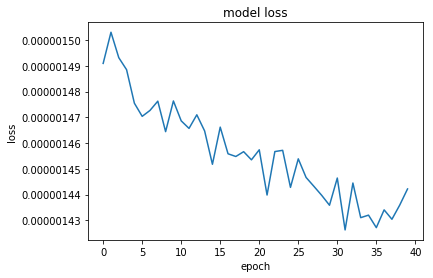

In [11]:
plt.figure()
plt.plot(history.history['loss'][10:])
plt.title('model loss') 
plt.ylabel('loss') 
plt.xlabel('epoch') 

In [12]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler2.inverse_transform(testPredict)
testY = scaler2.inverse_transform([testY])

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))


Train Score: 0.02 RMSE
Test Score: 0.03 RMSE


In [13]:
win = 0
lose = 0
for i, _ in enumerate(trainY[0]):
    if train_data_unscale[look_back - 1 + i] - trainY[0][i] > 0 and train_data_unscale[look_back - 1 + i] - trainPredict[i][0]> 0:
        win += 1
    elif train_data_unscale[look_back - 1 + i] - trainY[0][i] < 0 and train_data_unscale[look_back - 1 + i] - trainPredict[i][0]< 0:
        win += 1
    else:
        lose += 1
print(win/ (win+lose))

0.5017174381379991


In [14]:
testY_df = pd.DataFrame(testY[0])
test_predict_df = pd.DataFrame(testPredict[:,0])

print(testY_df.head(5), testY_df.shape)
print(test_predict_df.head(5), test_predict_df.shape)

           0
0  77.338000
1  77.282001
2  77.282993
3  77.282993
4  77.291002 (25898, 1)
           0
0  77.344383
1  77.345383
2  77.289330
3  77.290329
4  77.290329 (25898, 1)


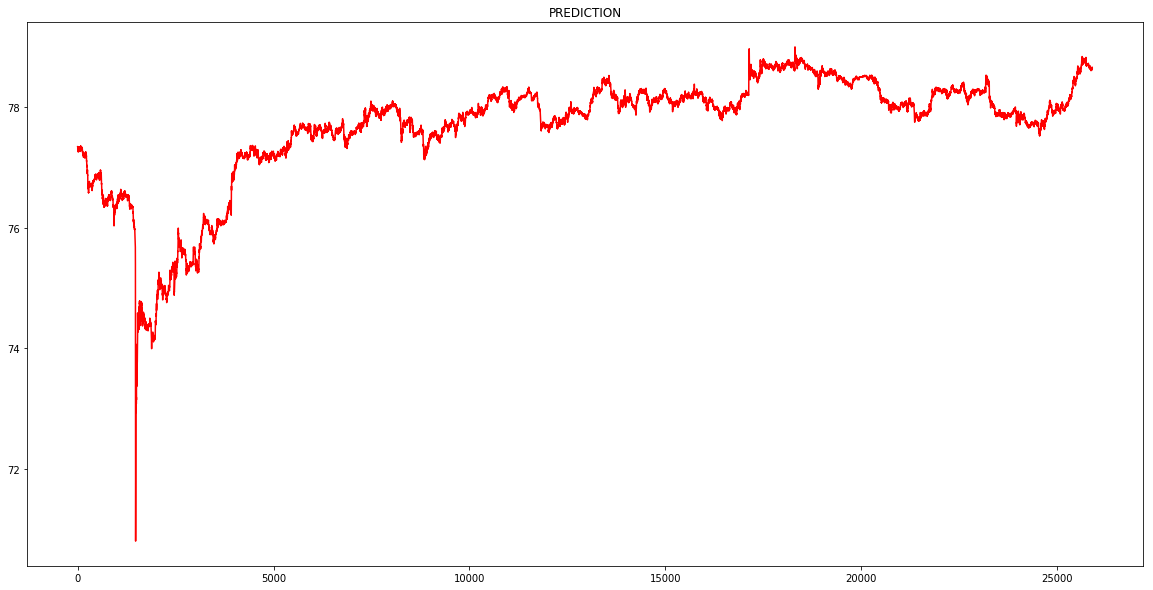

In [15]:
plt.figure(figsize=(20,10))
plt.plot(test_predict_df, color='red')
plt.title("PREDICTION")
plt.show()

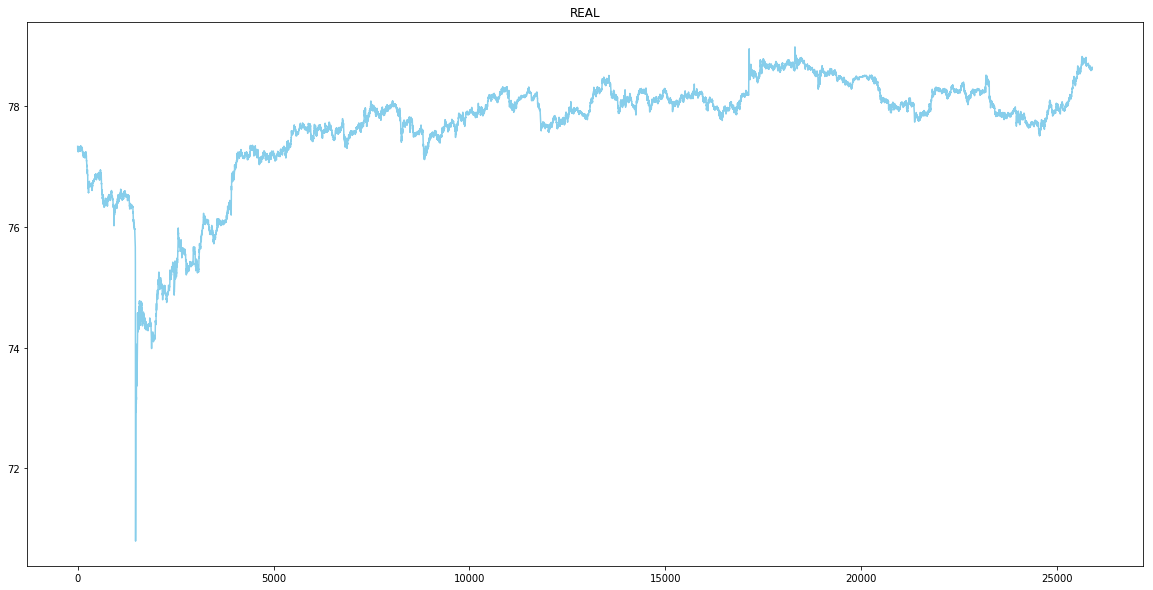

In [16]:
plt.figure(figsize=(20,10))
plt.plot(testY_df, color='skyblue')
plt.title("REAL")
plt.show()

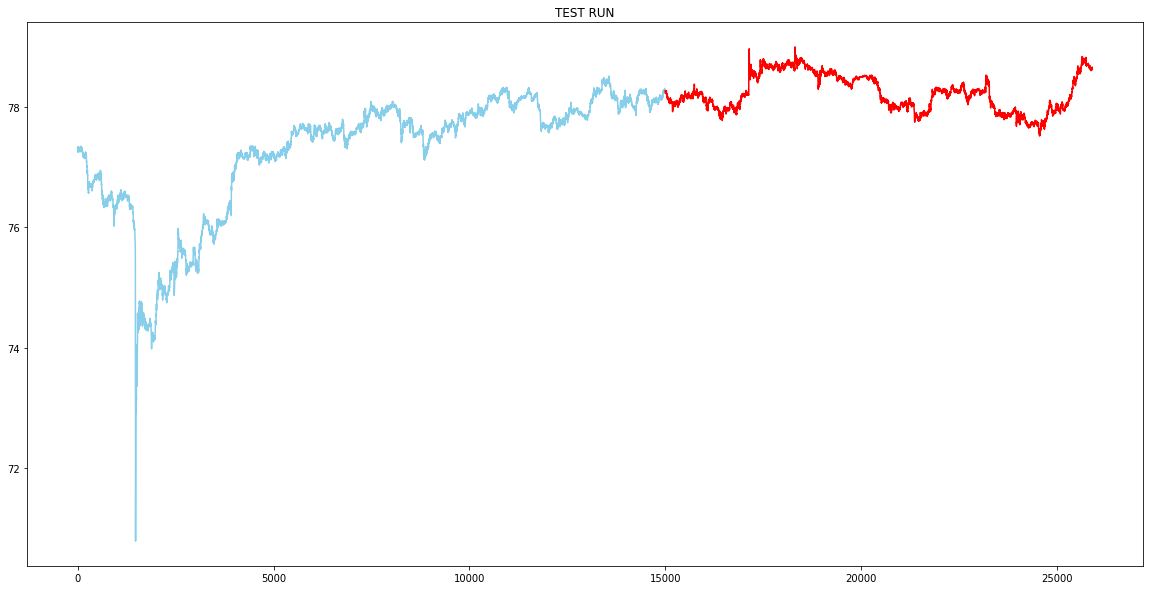

In [17]:
plt.figure(figsize=(20,10))
plt.plot(testY_df[:15000], color='skyblue')
plt.plot(test_predict_df[15000:], color='red')
plt.title("TEST RUN")
plt.show()

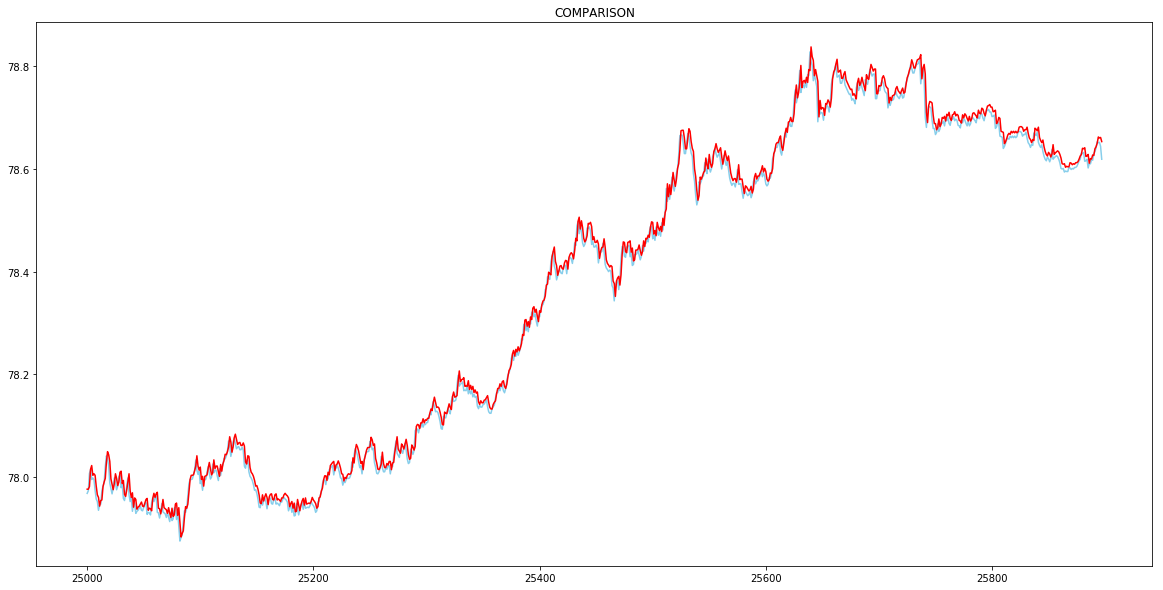

In [18]:
plt.figure(figsize=(20,10))
plt.plot(testY_df[25000:], color='skyblue')
plt.plot(test_predict_df[25000:], color='red')
plt.title("COMPARISON")
plt.show()

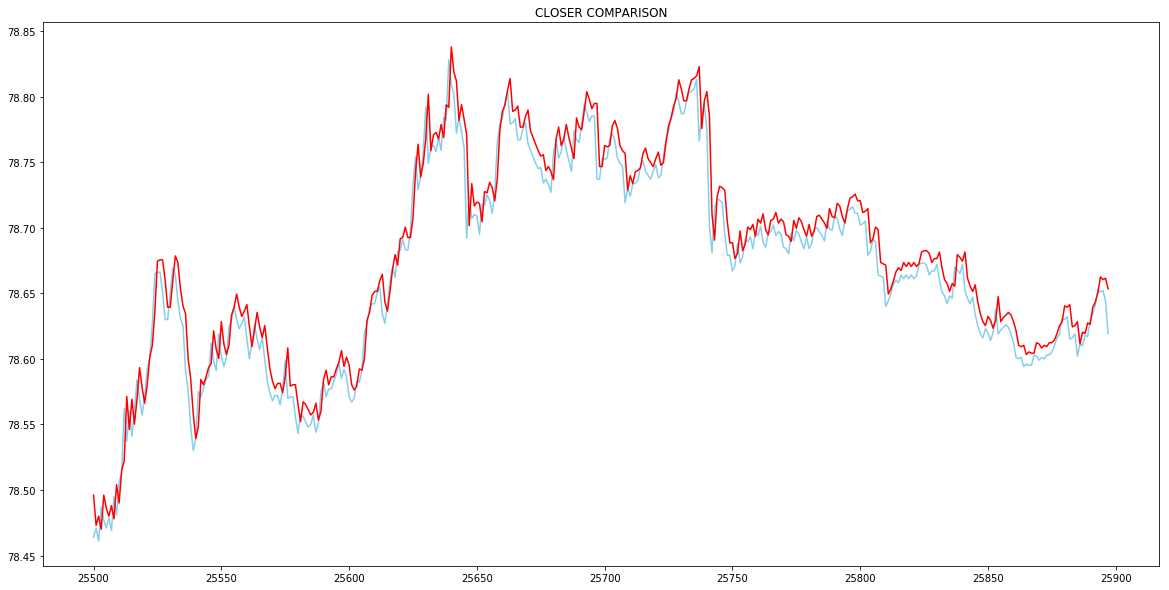

In [19]:
plt.figure(figsize=(20,10))
plt.plot(testY_df[25500:], color='skyblue')
plt.plot(test_predict_df[25500:], color='red')
plt.title("CLOSER COMPARISON")
plt.show()

### Predict the entire series from a start point

In [20]:
predict_all_through = []
start = testX[0][0].reshape(1,1,1)
for i in range(len(testX)):    
    temp = model.predict(start)
    predict_all_through.append(temp[0][0])
    start = temp.reshape(1,1,1)
    

In [21]:
print(predict_all_through)

[0.7995102, 0.80041236, 0.8013154, 0.8022194, 0.8031242, 0.8040299, 0.80493647, 0.80584395, 0.8067524, 0.80766165, 0.80857176, 0.8094829, 0.8103949, 0.81130785, 0.8122217, 0.8131365, 0.8140523, 0.8149689, 0.8158865, 0.816805, 0.8177245, 0.81864494, 0.81956637, 0.8204888, 0.82141215, 0.8223365, 0.8232619, 0.8241883, 0.8251157, 0.8260442, 0.8269737, 0.82790416, 0.82883567, 0.82976824, 0.8307018, 0.8316364, 0.83257204, 0.8335088, 0.83444667, 0.83538556, 0.8363256, 0.8372667, 0.83820885, 0.8391521, 0.8400965, 0.84104204, 0.8419887, 0.84293646, 0.84388536, 0.84483546, 0.8457867, 0.8467392, 0.8476927, 0.8486475, 0.8496033, 0.85056055, 0.85151887, 0.8524783, 0.85343903, 0.854401, 0.8553642, 0.85632867, 0.8572945, 0.85826147, 0.85922974, 0.8601993, 0.8611702, 0.8621423, 0.8631157, 0.8640904, 0.8650664, 0.86604387, 0.8670226, 0.8680028, 0.8689843, 0.8699672, 0.87095135, 0.871937, 0.872924, 0.8739124, 0.8749022, 0.8758934, 0.87688607, 0.87788016, 0.87887573, 0.87987286, 0.8808714, 0.88187146, 0.

In [22]:
for i, x in enumerate(predict_all_through):
    print(i, x)

0 0.7995102
1 0.80041236
2 0.8013154
3 0.8022194
4 0.8031242
5 0.8040299
6 0.80493647
7 0.80584395
8 0.8067524
9 0.80766165
10 0.80857176
11 0.8094829
12 0.8103949
13 0.81130785
14 0.8122217
15 0.8131365
16 0.8140523
17 0.8149689
18 0.8158865
19 0.816805
20 0.8177245
21 0.81864494
22 0.81956637
23 0.8204888
24 0.82141215
25 0.8223365
26 0.8232619
27 0.8241883
28 0.8251157
29 0.8260442
30 0.8269737
31 0.82790416
32 0.82883567
33 0.82976824
34 0.8307018
35 0.8316364
36 0.83257204
37 0.8335088
38 0.83444667
39 0.83538556
40 0.8363256
41 0.8372667
42 0.83820885
43 0.8391521
44 0.8400965
45 0.84104204
46 0.8419887
47 0.84293646
48 0.84388536
49 0.84483546
50 0.8457867
51 0.8467392
52 0.8476927
53 0.8486475
54 0.8496033
55 0.85056055
56 0.85151887
57 0.8524783
58 0.85343903
59 0.854401
60 0.8553642
61 0.85632867
62 0.8572945
63 0.85826147
64 0.85922974
65 0.8601993
66 0.8611702
67 0.8621423
68 0.8631157
69 0.8640904
70 0.8650664
71 0.86604387
72 0.8670226
73 0.8680028
74 0.8689843
75 0.86996

665 2.3082252
666 2.3082376
667 2.3082497
668 2.3082614
669 2.3082721
670 2.3082829
671 2.3082933
672 2.308303
673 2.3083124
674 2.3083215
675 2.3083303
676 2.3083389
677 2.308347
678 2.3083549
679 2.3083625
680 2.3083696
681 2.3083766
682 2.3083837
683 2.3083901
684 2.3083963
685 2.3084025
686 2.3084083
687 2.3084137
688 2.308419
689 2.308424
690 2.3084288
691 2.3084335
692 2.308438
693 2.3084426
694 2.308447
695 2.308451
696 2.3084548
697 2.3084588
698 2.3084626
699 2.3084662
700 2.3084695
701 2.3084726
702 2.3084762
703 2.308479
704 2.3084822
705 2.308485
706 2.3084877
707 2.3084903
708 2.3084924
709 2.3084948
710 2.308497
711 2.3084993
712 2.3085015
713 2.3085036
714 2.3085058
715 2.3085074
716 2.308509
717 2.3085108
718 2.3085124
719 2.308514
720 2.3085155
721 2.3085172
722 2.308519
723 2.30852
724 2.3085215
725 2.308523
726 2.3085241
727 2.308525
728 2.3085263
729 2.3085275
730 2.3085287
731 2.3085296
732 2.3085306
733 2.3085315
734 2.3085322
735 2.308533
736 2.308534
737 2.30853

1415 2.3085485
1416 2.3085485
1417 2.3085485
1418 2.3085485
1419 2.3085485
1420 2.3085485
1421 2.3085485
1422 2.3085485
1423 2.3085485
1424 2.3085485
1425 2.3085485
1426 2.3085485
1427 2.3085485
1428 2.3085485
1429 2.3085485
1430 2.3085485
1431 2.3085485
1432 2.3085485
1433 2.3085485
1434 2.3085485
1435 2.3085485
1436 2.3085485
1437 2.3085485
1438 2.3085485
1439 2.3085485
1440 2.3085485
1441 2.3085485
1442 2.3085485
1443 2.3085485
1444 2.3085485
1445 2.3085485
1446 2.3085485
1447 2.3085485
1448 2.3085485
1449 2.3085485
1450 2.3085485
1451 2.3085485
1452 2.3085485
1453 2.3085485
1454 2.3085485
1455 2.3085485
1456 2.3085485
1457 2.3085485
1458 2.3085485
1459 2.3085485
1460 2.3085485
1461 2.3085485
1462 2.3085485
1463 2.3085485
1464 2.3085485
1465 2.3085485
1466 2.3085485
1467 2.3085485
1468 2.3085485
1469 2.3085485
1470 2.3085485
1471 2.3085485
1472 2.3085485
1473 2.3085485
1474 2.3085485
1475 2.3085485
1476 2.3085485
1477 2.3085485
1478 2.3085485
1479 2.3085485
1480 2.3085485
1481 2.308

2165 2.3085485
2166 2.3085485
2167 2.3085485
2168 2.3085485
2169 2.3085485
2170 2.3085485
2171 2.3085485
2172 2.3085485
2173 2.3085485
2174 2.3085485
2175 2.3085485
2176 2.3085485
2177 2.3085485
2178 2.3085485
2179 2.3085485
2180 2.3085485
2181 2.3085485
2182 2.3085485
2183 2.3085485
2184 2.3085485
2185 2.3085485
2186 2.3085485
2187 2.3085485
2188 2.3085485
2189 2.3085485
2190 2.3085485
2191 2.3085485
2192 2.3085485
2193 2.3085485
2194 2.3085485
2195 2.3085485
2196 2.3085485
2197 2.3085485
2198 2.3085485
2199 2.3085485
2200 2.3085485
2201 2.3085485
2202 2.3085485
2203 2.3085485
2204 2.3085485
2205 2.3085485
2206 2.3085485
2207 2.3085485
2208 2.3085485
2209 2.3085485
2210 2.3085485
2211 2.3085485
2212 2.3085485
2213 2.3085485
2214 2.3085485
2215 2.3085485
2216 2.3085485
2217 2.3085485
2218 2.3085485
2219 2.3085485
2220 2.3085485
2221 2.3085485
2222 2.3085485
2223 2.3085485
2224 2.3085485
2225 2.3085485
2226 2.3085485
2227 2.3085485
2228 2.3085485
2229 2.3085485
2230 2.3085485
2231 2.308

3033 2.3085485
3034 2.3085485
3035 2.3085485
3036 2.3085485
3037 2.3085485
3038 2.3085485
3039 2.3085485
3040 2.3085485
3041 2.3085485
3042 2.3085485
3043 2.3085485
3044 2.3085485
3045 2.3085485
3046 2.3085485
3047 2.3085485
3048 2.3085485
3049 2.3085485
3050 2.3085485
3051 2.3085485
3052 2.3085485
3053 2.3085485
3054 2.3085485
3055 2.3085485
3056 2.3085485
3057 2.3085485
3058 2.3085485
3059 2.3085485
3060 2.3085485
3061 2.3085485
3062 2.3085485
3063 2.3085485
3064 2.3085485
3065 2.3085485
3066 2.3085485
3067 2.3085485
3068 2.3085485
3069 2.3085485
3070 2.3085485
3071 2.3085485
3072 2.3085485
3073 2.3085485
3074 2.3085485
3075 2.3085485
3076 2.3085485
3077 2.3085485
3078 2.3085485
3079 2.3085485
3080 2.3085485
3081 2.3085485
3082 2.3085485
3083 2.3085485
3084 2.3085485
3085 2.3085485
3086 2.3085485
3087 2.3085485
3088 2.3085485
3089 2.3085485
3090 2.3085485
3091 2.3085485
3092 2.3085485
3093 2.3085485
3094 2.3085485
3095 2.3085485
3096 2.3085485
3097 2.3085485
3098 2.3085485
3099 2.308

3914 2.3085485
3915 2.3085485
3916 2.3085485
3917 2.3085485
3918 2.3085485
3919 2.3085485
3920 2.3085485
3921 2.3085485
3922 2.3085485
3923 2.3085485
3924 2.3085485
3925 2.3085485
3926 2.3085485
3927 2.3085485
3928 2.3085485
3929 2.3085485
3930 2.3085485
3931 2.3085485
3932 2.3085485
3933 2.3085485
3934 2.3085485
3935 2.3085485
3936 2.3085485
3937 2.3085485
3938 2.3085485
3939 2.3085485
3940 2.3085485
3941 2.3085485
3942 2.3085485
3943 2.3085485
3944 2.3085485
3945 2.3085485
3946 2.3085485
3947 2.3085485
3948 2.3085485
3949 2.3085485
3950 2.3085485
3951 2.3085485
3952 2.3085485
3953 2.3085485
3954 2.3085485
3955 2.3085485
3956 2.3085485
3957 2.3085485
3958 2.3085485
3959 2.3085485
3960 2.3085485
3961 2.3085485
3962 2.3085485
3963 2.3085485
3964 2.3085485
3965 2.3085485
3966 2.3085485
3967 2.3085485
3968 2.3085485
3969 2.3085485
3970 2.3085485
3971 2.3085485
3972 2.3085485
3973 2.3085485
3974 2.3085485
3975 2.3085485
3976 2.3085485
3977 2.3085485
3978 2.3085485
3979 2.3085485
3980 2.308

4664 2.3085485
4665 2.3085485
4666 2.3085485
4667 2.3085485
4668 2.3085485
4669 2.3085485
4670 2.3085485
4671 2.3085485
4672 2.3085485
4673 2.3085485
4674 2.3085485
4675 2.3085485
4676 2.3085485
4677 2.3085485
4678 2.3085485
4679 2.3085485
4680 2.3085485
4681 2.3085485
4682 2.3085485
4683 2.3085485
4684 2.3085485
4685 2.3085485
4686 2.3085485
4687 2.3085485
4688 2.3085485
4689 2.3085485
4690 2.3085485
4691 2.3085485
4692 2.3085485
4693 2.3085485
4694 2.3085485
4695 2.3085485
4696 2.3085485
4697 2.3085485
4698 2.3085485
4699 2.3085485
4700 2.3085485
4701 2.3085485
4702 2.3085485
4703 2.3085485
4704 2.3085485
4705 2.3085485
4706 2.3085485
4707 2.3085485
4708 2.3085485
4709 2.3085485
4710 2.3085485
4711 2.3085485
4712 2.3085485
4713 2.3085485
4714 2.3085485
4715 2.3085485
4716 2.3085485
4717 2.3085485
4718 2.3085485
4719 2.3085485
4720 2.3085485
4721 2.3085485
4722 2.3085485
4723 2.3085485
4724 2.3085485
4725 2.3085485
4726 2.3085485
4727 2.3085485
4728 2.3085485
4729 2.3085485
4730 2.308

5414 2.3085485
5415 2.3085485
5416 2.3085485
5417 2.3085485
5418 2.3085485
5419 2.3085485
5420 2.3085485
5421 2.3085485
5422 2.3085485
5423 2.3085485
5424 2.3085485
5425 2.3085485
5426 2.3085485
5427 2.3085485
5428 2.3085485
5429 2.3085485
5430 2.3085485
5431 2.3085485
5432 2.3085485
5433 2.3085485
5434 2.3085485
5435 2.3085485
5436 2.3085485
5437 2.3085485
5438 2.3085485
5439 2.3085485
5440 2.3085485
5441 2.3085485
5442 2.3085485
5443 2.3085485
5444 2.3085485
5445 2.3085485
5446 2.3085485
5447 2.3085485
5448 2.3085485
5449 2.3085485
5450 2.3085485
5451 2.3085485
5452 2.3085485
5453 2.3085485
5454 2.3085485
5455 2.3085485
5456 2.3085485
5457 2.3085485
5458 2.3085485
5459 2.3085485
5460 2.3085485
5461 2.3085485
5462 2.3085485
5463 2.3085485
5464 2.3085485
5465 2.3085485
5466 2.3085485
5467 2.3085485
5468 2.3085485
5469 2.3085485
5470 2.3085485
5471 2.3085485
5472 2.3085485
5473 2.3085485
5474 2.3085485
5475 2.3085485
5476 2.3085485
5477 2.3085485
5478 2.3085485
5479 2.3085485
5480 2.308

6216 2.3085485
6217 2.3085485
6218 2.3085485
6219 2.3085485
6220 2.3085485
6221 2.3085485
6222 2.3085485
6223 2.3085485
6224 2.3085485
6225 2.3085485
6226 2.3085485
6227 2.3085485
6228 2.3085485
6229 2.3085485
6230 2.3085485
6231 2.3085485
6232 2.3085485
6233 2.3085485
6234 2.3085485
6235 2.3085485
6236 2.3085485
6237 2.3085485
6238 2.3085485
6239 2.3085485
6240 2.3085485
6241 2.3085485
6242 2.3085485
6243 2.3085485
6244 2.3085485
6245 2.3085485
6246 2.3085485
6247 2.3085485
6248 2.3085485
6249 2.3085485
6250 2.3085485
6251 2.3085485
6252 2.3085485
6253 2.3085485
6254 2.3085485
6255 2.3085485
6256 2.3085485
6257 2.3085485
6258 2.3085485
6259 2.3085485
6260 2.3085485
6261 2.3085485
6262 2.3085485
6263 2.3085485
6264 2.3085485
6265 2.3085485
6266 2.3085485
6267 2.3085485
6268 2.3085485
6269 2.3085485
6270 2.3085485
6271 2.3085485
6272 2.3085485
6273 2.3085485
6274 2.3085485
6275 2.3085485
6276 2.3085485
6277 2.3085485
6278 2.3085485
6279 2.3085485
6280 2.3085485
6281 2.3085485
6282 2.308

7163 2.3085485
7164 2.3085485
7165 2.3085485
7166 2.3085485
7167 2.3085485
7168 2.3085485
7169 2.3085485
7170 2.3085485
7171 2.3085485
7172 2.3085485
7173 2.3085485
7174 2.3085485
7175 2.3085485
7176 2.3085485
7177 2.3085485
7178 2.3085485
7179 2.3085485
7180 2.3085485
7181 2.3085485
7182 2.3085485
7183 2.3085485
7184 2.3085485
7185 2.3085485
7186 2.3085485
7187 2.3085485
7188 2.3085485
7189 2.3085485
7190 2.3085485
7191 2.3085485
7192 2.3085485
7193 2.3085485
7194 2.3085485
7195 2.3085485
7196 2.3085485
7197 2.3085485
7198 2.3085485
7199 2.3085485
7200 2.3085485
7201 2.3085485
7202 2.3085485
7203 2.3085485
7204 2.3085485
7205 2.3085485
7206 2.3085485
7207 2.3085485
7208 2.3085485
7209 2.3085485
7210 2.3085485
7211 2.3085485
7212 2.3085485
7213 2.3085485
7214 2.3085485
7215 2.3085485
7216 2.3085485
7217 2.3085485
7218 2.3085485
7219 2.3085485
7220 2.3085485
7221 2.3085485
7222 2.3085485
7223 2.3085485
7224 2.3085485
7225 2.3085485
7226 2.3085485
7227 2.3085485
7228 2.3085485
7229 2.308

8015 2.3085485
8016 2.3085485
8017 2.3085485
8018 2.3085485
8019 2.3085485
8020 2.3085485
8021 2.3085485
8022 2.3085485
8023 2.3085485
8024 2.3085485
8025 2.3085485
8026 2.3085485
8027 2.3085485
8028 2.3085485
8029 2.3085485
8030 2.3085485
8031 2.3085485
8032 2.3085485
8033 2.3085485
8034 2.3085485
8035 2.3085485
8036 2.3085485
8037 2.3085485
8038 2.3085485
8039 2.3085485
8040 2.3085485
8041 2.3085485
8042 2.3085485
8043 2.3085485
8044 2.3085485
8045 2.3085485
8046 2.3085485
8047 2.3085485
8048 2.3085485
8049 2.3085485
8050 2.3085485
8051 2.3085485
8052 2.3085485
8053 2.3085485
8054 2.3085485
8055 2.3085485
8056 2.3085485
8057 2.3085485
8058 2.3085485
8059 2.3085485
8060 2.3085485
8061 2.3085485
8062 2.3085485
8063 2.3085485
8064 2.3085485
8065 2.3085485
8066 2.3085485
8067 2.3085485
8068 2.3085485
8069 2.3085485
8070 2.3085485
8071 2.3085485
8072 2.3085485
8073 2.3085485
8074 2.3085485
8075 2.3085485
8076 2.3085485
8077 2.3085485
8078 2.3085485
8079 2.3085485
8080 2.3085485
8081 2.308

8913 2.3085485
8914 2.3085485
8915 2.3085485
8916 2.3085485
8917 2.3085485
8918 2.3085485
8919 2.3085485
8920 2.3085485
8921 2.3085485
8922 2.3085485
8923 2.3085485
8924 2.3085485
8925 2.3085485
8926 2.3085485
8927 2.3085485
8928 2.3085485
8929 2.3085485
8930 2.3085485
8931 2.3085485
8932 2.3085485
8933 2.3085485
8934 2.3085485
8935 2.3085485
8936 2.3085485
8937 2.3085485
8938 2.3085485
8939 2.3085485
8940 2.3085485
8941 2.3085485
8942 2.3085485
8943 2.3085485
8944 2.3085485
8945 2.3085485
8946 2.3085485
8947 2.3085485
8948 2.3085485
8949 2.3085485
8950 2.3085485
8951 2.3085485
8952 2.3085485
8953 2.3085485
8954 2.3085485
8955 2.3085485
8956 2.3085485
8957 2.3085485
8958 2.3085485
8959 2.3085485
8960 2.3085485
8961 2.3085485
8962 2.3085485
8963 2.3085485
8964 2.3085485
8965 2.3085485
8966 2.3085485
8967 2.3085485
8968 2.3085485
8969 2.3085485
8970 2.3085485
8971 2.3085485
8972 2.3085485
8973 2.3085485
8974 2.3085485
8975 2.3085485
8976 2.3085485
8977 2.3085485
8978 2.3085485
8979 2.308

9662 2.3085485
9663 2.3085485
9664 2.3085485
9665 2.3085485
9666 2.3085485
9667 2.3085485
9668 2.3085485
9669 2.3085485
9670 2.3085485
9671 2.3085485
9672 2.3085485
9673 2.3085485
9674 2.3085485
9675 2.3085485
9676 2.3085485
9677 2.3085485
9678 2.3085485
9679 2.3085485
9680 2.3085485
9681 2.3085485
9682 2.3085485
9683 2.3085485
9684 2.3085485
9685 2.3085485
9686 2.3085485
9687 2.3085485
9688 2.3085485
9689 2.3085485
9690 2.3085485
9691 2.3085485
9692 2.3085485
9693 2.3085485
9694 2.3085485
9695 2.3085485
9696 2.3085485
9697 2.3085485
9698 2.3085485
9699 2.3085485
9700 2.3085485
9701 2.3085485
9702 2.3085485
9703 2.3085485
9704 2.3085485
9705 2.3085485
9706 2.3085485
9707 2.3085485
9708 2.3085485
9709 2.3085485
9710 2.3085485
9711 2.3085485
9712 2.3085485
9713 2.3085485
9714 2.3085485
9715 2.3085485
9716 2.3085485
9717 2.3085485
9718 2.3085485
9719 2.3085485
9720 2.3085485
9721 2.3085485
9722 2.3085485
9723 2.3085485
9724 2.3085485
9725 2.3085485
9726 2.3085485
9727 2.3085485
9728 2.308

10480 2.3085485
10481 2.3085485
10482 2.3085485
10483 2.3085485
10484 2.3085485
10485 2.3085485
10486 2.3085485
10487 2.3085485
10488 2.3085485
10489 2.3085485
10490 2.3085485
10491 2.3085485
10492 2.3085485
10493 2.3085485
10494 2.3085485
10495 2.3085485
10496 2.3085485
10497 2.3085485
10498 2.3085485
10499 2.3085485
10500 2.3085485
10501 2.3085485
10502 2.3085485
10503 2.3085485
10504 2.3085485
10505 2.3085485
10506 2.3085485
10507 2.3085485
10508 2.3085485
10509 2.3085485
10510 2.3085485
10511 2.3085485
10512 2.3085485
10513 2.3085485
10514 2.3085485
10515 2.3085485
10516 2.3085485
10517 2.3085485
10518 2.3085485
10519 2.3085485
10520 2.3085485
10521 2.3085485
10522 2.3085485
10523 2.3085485
10524 2.3085485
10525 2.3085485
10526 2.3085485
10527 2.3085485
10528 2.3085485
10529 2.3085485
10530 2.3085485
10531 2.3085485
10532 2.3085485
10533 2.3085485
10534 2.3085485
10535 2.3085485
10536 2.3085485
10537 2.3085485
10538 2.3085485
10539 2.3085485
10540 2.3085485
10541 2.3085485
10542 2.

11412 2.3085485
11413 2.3085485
11414 2.3085485
11415 2.3085485
11416 2.3085485
11417 2.3085485
11418 2.3085485
11419 2.3085485
11420 2.3085485
11421 2.3085485
11422 2.3085485
11423 2.3085485
11424 2.3085485
11425 2.3085485
11426 2.3085485
11427 2.3085485
11428 2.3085485
11429 2.3085485
11430 2.3085485
11431 2.3085485
11432 2.3085485
11433 2.3085485
11434 2.3085485
11435 2.3085485
11436 2.3085485
11437 2.3085485
11438 2.3085485
11439 2.3085485
11440 2.3085485
11441 2.3085485
11442 2.3085485
11443 2.3085485
11444 2.3085485
11445 2.3085485
11446 2.3085485
11447 2.3085485
11448 2.3085485
11449 2.3085485
11450 2.3085485
11451 2.3085485
11452 2.3085485
11453 2.3085485
11454 2.3085485
11455 2.3085485
11456 2.3085485
11457 2.3085485
11458 2.3085485
11459 2.3085485
11460 2.3085485
11461 2.3085485
11462 2.3085485
11463 2.3085485
11464 2.3085485
11465 2.3085485
11466 2.3085485
11467 2.3085485
11468 2.3085485
11469 2.3085485
11470 2.3085485
11471 2.3085485
11472 2.3085485
11473 2.3085485
11474 2.

12412 2.3085485
12413 2.3085485
12414 2.3085485
12415 2.3085485
12416 2.3085485
12417 2.3085485
12418 2.3085485
12419 2.3085485
12420 2.3085485
12421 2.3085485
12422 2.3085485
12423 2.3085485
12424 2.3085485
12425 2.3085485
12426 2.3085485
12427 2.3085485
12428 2.3085485
12429 2.3085485
12430 2.3085485
12431 2.3085485
12432 2.3085485
12433 2.3085485
12434 2.3085485
12435 2.3085485
12436 2.3085485
12437 2.3085485
12438 2.3085485
12439 2.3085485
12440 2.3085485
12441 2.3085485
12442 2.3085485
12443 2.3085485
12444 2.3085485
12445 2.3085485
12446 2.3085485
12447 2.3085485
12448 2.3085485
12449 2.3085485
12450 2.3085485
12451 2.3085485
12452 2.3085485
12453 2.3085485
12454 2.3085485
12455 2.3085485
12456 2.3085485
12457 2.3085485
12458 2.3085485
12459 2.3085485
12460 2.3085485
12461 2.3085485
12462 2.3085485
12463 2.3085485
12464 2.3085485
12465 2.3085485
12466 2.3085485
12467 2.3085485
12468 2.3085485
12469 2.3085485
12470 2.3085485
12471 2.3085485
12472 2.3085485
12473 2.3085485
12474 2.

13287 2.3085485
13288 2.3085485
13289 2.3085485
13290 2.3085485
13291 2.3085485
13292 2.3085485
13293 2.3085485
13294 2.3085485
13295 2.3085485
13296 2.3085485
13297 2.3085485
13298 2.3085485
13299 2.3085485
13300 2.3085485
13301 2.3085485
13302 2.3085485
13303 2.3085485
13304 2.3085485
13305 2.3085485
13306 2.3085485
13307 2.3085485
13308 2.3085485
13309 2.3085485
13310 2.3085485
13311 2.3085485
13312 2.3085485
13313 2.3085485
13314 2.3085485
13315 2.3085485
13316 2.3085485
13317 2.3085485
13318 2.3085485
13319 2.3085485
13320 2.3085485
13321 2.3085485
13322 2.3085485
13323 2.3085485
13324 2.3085485
13325 2.3085485
13326 2.3085485
13327 2.3085485
13328 2.3085485
13329 2.3085485
13330 2.3085485
13331 2.3085485
13332 2.3085485
13333 2.3085485
13334 2.3085485
13335 2.3085485
13336 2.3085485
13337 2.3085485
13338 2.3085485
13339 2.3085485
13340 2.3085485
13341 2.3085485
13342 2.3085485
13343 2.3085485
13344 2.3085485
13345 2.3085485
13346 2.3085485
13347 2.3085485
13348 2.3085485
13349 2.

14311 2.3085485
14312 2.3085485
14313 2.3085485
14314 2.3085485
14315 2.3085485
14316 2.3085485
14317 2.3085485
14318 2.3085485
14319 2.3085485
14320 2.3085485
14321 2.3085485
14322 2.3085485
14323 2.3085485
14324 2.3085485
14325 2.3085485
14326 2.3085485
14327 2.3085485
14328 2.3085485
14329 2.3085485
14330 2.3085485
14331 2.3085485
14332 2.3085485
14333 2.3085485
14334 2.3085485
14335 2.3085485
14336 2.3085485
14337 2.3085485
14338 2.3085485
14339 2.3085485
14340 2.3085485
14341 2.3085485
14342 2.3085485
14343 2.3085485
14344 2.3085485
14345 2.3085485
14346 2.3085485
14347 2.3085485
14348 2.3085485
14349 2.3085485
14350 2.3085485
14351 2.3085485
14352 2.3085485
14353 2.3085485
14354 2.3085485
14355 2.3085485
14356 2.3085485
14357 2.3085485
14358 2.3085485
14359 2.3085485
14360 2.3085485
14361 2.3085485
14362 2.3085485
14363 2.3085485
14364 2.3085485
14365 2.3085485
14366 2.3085485
14367 2.3085485
14368 2.3085485
14369 2.3085485
14370 2.3085485
14371 2.3085485
14372 2.3085485
14373 2.

15161 2.3085485
15162 2.3085485
15163 2.3085485
15164 2.3085485
15165 2.3085485
15166 2.3085485
15167 2.3085485
15168 2.3085485
15169 2.3085485
15170 2.3085485
15171 2.3085485
15172 2.3085485
15173 2.3085485
15174 2.3085485
15175 2.3085485
15176 2.3085485
15177 2.3085485
15178 2.3085485
15179 2.3085485
15180 2.3085485
15181 2.3085485
15182 2.3085485
15183 2.3085485
15184 2.3085485
15185 2.3085485
15186 2.3085485
15187 2.3085485
15188 2.3085485
15189 2.3085485
15190 2.3085485
15191 2.3085485
15192 2.3085485
15193 2.3085485
15194 2.3085485
15195 2.3085485
15196 2.3085485
15197 2.3085485
15198 2.3085485
15199 2.3085485
15200 2.3085485
15201 2.3085485
15202 2.3085485
15203 2.3085485
15204 2.3085485
15205 2.3085485
15206 2.3085485
15207 2.3085485
15208 2.3085485
15209 2.3085485
15210 2.3085485
15211 2.3085485
15212 2.3085485
15213 2.3085485
15214 2.3085485
15215 2.3085485
15216 2.3085485
15217 2.3085485
15218 2.3085485
15219 2.3085485
15220 2.3085485
15221 2.3085485
15222 2.3085485
15223 2.

16035 2.3085485
16036 2.3085485
16037 2.3085485
16038 2.3085485
16039 2.3085485
16040 2.3085485
16041 2.3085485
16042 2.3085485
16043 2.3085485
16044 2.3085485
16045 2.3085485
16046 2.3085485
16047 2.3085485
16048 2.3085485
16049 2.3085485
16050 2.3085485
16051 2.3085485
16052 2.3085485
16053 2.3085485
16054 2.3085485
16055 2.3085485
16056 2.3085485
16057 2.3085485
16058 2.3085485
16059 2.3085485
16060 2.3085485
16061 2.3085485
16062 2.3085485
16063 2.3085485
16064 2.3085485
16065 2.3085485
16066 2.3085485
16067 2.3085485
16068 2.3085485
16069 2.3085485
16070 2.3085485
16071 2.3085485
16072 2.3085485
16073 2.3085485
16074 2.3085485
16075 2.3085485
16076 2.3085485
16077 2.3085485
16078 2.3085485
16079 2.3085485
16080 2.3085485
16081 2.3085485
16082 2.3085485
16083 2.3085485
16084 2.3085485
16085 2.3085485
16086 2.3085485
16087 2.3085485
16088 2.3085485
16089 2.3085485
16090 2.3085485
16091 2.3085485
16092 2.3085485
16093 2.3085485
16094 2.3085485
16095 2.3085485
16096 2.3085485
16097 2.

16910 2.3085485
16911 2.3085485
16912 2.3085485
16913 2.3085485
16914 2.3085485
16915 2.3085485
16916 2.3085485
16917 2.3085485
16918 2.3085485
16919 2.3085485
16920 2.3085485
16921 2.3085485
16922 2.3085485
16923 2.3085485
16924 2.3085485
16925 2.3085485
16926 2.3085485
16927 2.3085485
16928 2.3085485
16929 2.3085485
16930 2.3085485
16931 2.3085485
16932 2.3085485
16933 2.3085485
16934 2.3085485
16935 2.3085485
16936 2.3085485
16937 2.3085485
16938 2.3085485
16939 2.3085485
16940 2.3085485
16941 2.3085485
16942 2.3085485
16943 2.3085485
16944 2.3085485
16945 2.3085485
16946 2.3085485
16947 2.3085485
16948 2.3085485
16949 2.3085485
16950 2.3085485
16951 2.3085485
16952 2.3085485
16953 2.3085485
16954 2.3085485
16955 2.3085485
16956 2.3085485
16957 2.3085485
16958 2.3085485
16959 2.3085485
16960 2.3085485
16961 2.3085485
16962 2.3085485
16963 2.3085485
16964 2.3085485
16965 2.3085485
16966 2.3085485
16967 2.3085485
16968 2.3085485
16969 2.3085485
16970 2.3085485
16971 2.3085485
16972 2.

17889 2.3085485
17890 2.3085485
17891 2.3085485
17892 2.3085485
17893 2.3085485
17894 2.3085485
17895 2.3085485
17896 2.3085485
17897 2.3085485
17898 2.3085485
17899 2.3085485
17900 2.3085485
17901 2.3085485
17902 2.3085485
17903 2.3085485
17904 2.3085485
17905 2.3085485
17906 2.3085485
17907 2.3085485
17908 2.3085485
17909 2.3085485
17910 2.3085485
17911 2.3085485
17912 2.3085485
17913 2.3085485
17914 2.3085485
17915 2.3085485
17916 2.3085485
17917 2.3085485
17918 2.3085485
17919 2.3085485
17920 2.3085485
17921 2.3085485
17922 2.3085485
17923 2.3085485
17924 2.3085485
17925 2.3085485
17926 2.3085485
17927 2.3085485
17928 2.3085485
17929 2.3085485
17930 2.3085485
17931 2.3085485
17932 2.3085485
17933 2.3085485
17934 2.3085485
17935 2.3085485
17936 2.3085485
17937 2.3085485
17938 2.3085485
17939 2.3085485
17940 2.3085485
17941 2.3085485
17942 2.3085485
17943 2.3085485
17944 2.3085485
17945 2.3085485
17946 2.3085485
17947 2.3085485
17948 2.3085485
17949 2.3085485
17950 2.3085485
17951 2.

18805 2.3085485
18806 2.3085485
18807 2.3085485
18808 2.3085485
18809 2.3085485
18810 2.3085485
18811 2.3085485
18812 2.3085485
18813 2.3085485
18814 2.3085485
18815 2.3085485
18816 2.3085485
18817 2.3085485
18818 2.3085485
18819 2.3085485
18820 2.3085485
18821 2.3085485
18822 2.3085485
18823 2.3085485
18824 2.3085485
18825 2.3085485
18826 2.3085485
18827 2.3085485
18828 2.3085485
18829 2.3085485
18830 2.3085485
18831 2.3085485
18832 2.3085485
18833 2.3085485
18834 2.3085485
18835 2.3085485
18836 2.3085485
18837 2.3085485
18838 2.3085485
18839 2.3085485
18840 2.3085485
18841 2.3085485
18842 2.3085485
18843 2.3085485
18844 2.3085485
18845 2.3085485
18846 2.3085485
18847 2.3085485
18848 2.3085485
18849 2.3085485
18850 2.3085485
18851 2.3085485
18852 2.3085485
18853 2.3085485
18854 2.3085485
18855 2.3085485
18856 2.3085485
18857 2.3085485
18858 2.3085485
18859 2.3085485
18860 2.3085485
18861 2.3085485
18862 2.3085485
18863 2.3085485
18864 2.3085485
18865 2.3085485
18866 2.3085485
18867 2.

19624 2.3085485
19625 2.3085485
19626 2.3085485
19627 2.3085485
19628 2.3085485
19629 2.3085485
19630 2.3085485
19631 2.3085485
19632 2.3085485
19633 2.3085485
19634 2.3085485
19635 2.3085485
19636 2.3085485
19637 2.3085485
19638 2.3085485
19639 2.3085485
19640 2.3085485
19641 2.3085485
19642 2.3085485
19643 2.3085485
19644 2.3085485
19645 2.3085485
19646 2.3085485
19647 2.3085485
19648 2.3085485
19649 2.3085485
19650 2.3085485
19651 2.3085485
19652 2.3085485
19653 2.3085485
19654 2.3085485
19655 2.3085485
19656 2.3085485
19657 2.3085485
19658 2.3085485
19659 2.3085485
19660 2.3085485
19661 2.3085485
19662 2.3085485
19663 2.3085485
19664 2.3085485
19665 2.3085485
19666 2.3085485
19667 2.3085485
19668 2.3085485
19669 2.3085485
19670 2.3085485
19671 2.3085485
19672 2.3085485
19673 2.3085485
19674 2.3085485
19675 2.3085485
19676 2.3085485
19677 2.3085485
19678 2.3085485
19679 2.3085485
19680 2.3085485
19681 2.3085485
19682 2.3085485
19683 2.3085485
19684 2.3085485
19685 2.3085485
19686 2.

20450 2.3085485
20451 2.3085485
20452 2.3085485
20453 2.3085485
20454 2.3085485
20455 2.3085485
20456 2.3085485
20457 2.3085485
20458 2.3085485
20459 2.3085485
20460 2.3085485
20461 2.3085485
20462 2.3085485
20463 2.3085485
20464 2.3085485
20465 2.3085485
20466 2.3085485
20467 2.3085485
20468 2.3085485
20469 2.3085485
20470 2.3085485
20471 2.3085485
20472 2.3085485
20473 2.3085485
20474 2.3085485
20475 2.3085485
20476 2.3085485
20477 2.3085485
20478 2.3085485
20479 2.3085485
20480 2.3085485
20481 2.3085485
20482 2.3085485
20483 2.3085485
20484 2.3085485
20485 2.3085485
20486 2.3085485
20487 2.3085485
20488 2.3085485
20489 2.3085485
20490 2.3085485
20491 2.3085485
20492 2.3085485
20493 2.3085485
20494 2.3085485
20495 2.3085485
20496 2.3085485
20497 2.3085485
20498 2.3085485
20499 2.3085485
20500 2.3085485
20501 2.3085485
20502 2.3085485
20503 2.3085485
20504 2.3085485
20505 2.3085485
20506 2.3085485
20507 2.3085485
20508 2.3085485
20509 2.3085485
20510 2.3085485
20511 2.3085485
20512 2.

21409 2.3085485
21410 2.3085485
21411 2.3085485
21412 2.3085485
21413 2.3085485
21414 2.3085485
21415 2.3085485
21416 2.3085485
21417 2.3085485
21418 2.3085485
21419 2.3085485
21420 2.3085485
21421 2.3085485
21422 2.3085485
21423 2.3085485
21424 2.3085485
21425 2.3085485
21426 2.3085485
21427 2.3085485
21428 2.3085485
21429 2.3085485
21430 2.3085485
21431 2.3085485
21432 2.3085485
21433 2.3085485
21434 2.3085485
21435 2.3085485
21436 2.3085485
21437 2.3085485
21438 2.3085485
21439 2.3085485
21440 2.3085485
21441 2.3085485
21442 2.3085485
21443 2.3085485
21444 2.3085485
21445 2.3085485
21446 2.3085485
21447 2.3085485
21448 2.3085485
21449 2.3085485
21450 2.3085485
21451 2.3085485
21452 2.3085485
21453 2.3085485
21454 2.3085485
21455 2.3085485
21456 2.3085485
21457 2.3085485
21458 2.3085485
21459 2.3085485
21460 2.3085485
21461 2.3085485
21462 2.3085485
21463 2.3085485
21464 2.3085485
21465 2.3085485
21466 2.3085485
21467 2.3085485
21468 2.3085485
21469 2.3085485
21470 2.3085485
21471 2.

22260 2.3085485
22261 2.3085485
22262 2.3085485
22263 2.3085485
22264 2.3085485
22265 2.3085485
22266 2.3085485
22267 2.3085485
22268 2.3085485
22269 2.3085485
22270 2.3085485
22271 2.3085485
22272 2.3085485
22273 2.3085485
22274 2.3085485
22275 2.3085485
22276 2.3085485
22277 2.3085485
22278 2.3085485
22279 2.3085485
22280 2.3085485
22281 2.3085485
22282 2.3085485
22283 2.3085485
22284 2.3085485
22285 2.3085485
22286 2.3085485
22287 2.3085485
22288 2.3085485
22289 2.3085485
22290 2.3085485
22291 2.3085485
22292 2.3085485
22293 2.3085485
22294 2.3085485
22295 2.3085485
22296 2.3085485
22297 2.3085485
22298 2.3085485
22299 2.3085485
22300 2.3085485
22301 2.3085485
22302 2.3085485
22303 2.3085485
22304 2.3085485
22305 2.3085485
22306 2.3085485
22307 2.3085485
22308 2.3085485
22309 2.3085485
22310 2.3085485
22311 2.3085485
22312 2.3085485
22313 2.3085485
22314 2.3085485
22315 2.3085485
22316 2.3085485
22317 2.3085485
22318 2.3085485
22319 2.3085485
22320 2.3085485
22321 2.3085485
22322 2.

23159 2.3085485
23160 2.3085485
23161 2.3085485
23162 2.3085485
23163 2.3085485
23164 2.3085485
23165 2.3085485
23166 2.3085485
23167 2.3085485
23168 2.3085485
23169 2.3085485
23170 2.3085485
23171 2.3085485
23172 2.3085485
23173 2.3085485
23174 2.3085485
23175 2.3085485
23176 2.3085485
23177 2.3085485
23178 2.3085485
23179 2.3085485
23180 2.3085485
23181 2.3085485
23182 2.3085485
23183 2.3085485
23184 2.3085485
23185 2.3085485
23186 2.3085485
23187 2.3085485
23188 2.3085485
23189 2.3085485
23190 2.3085485
23191 2.3085485
23192 2.3085485
23193 2.3085485
23194 2.3085485
23195 2.3085485
23196 2.3085485
23197 2.3085485
23198 2.3085485
23199 2.3085485
23200 2.3085485
23201 2.3085485
23202 2.3085485
23203 2.3085485
23204 2.3085485
23205 2.3085485
23206 2.3085485
23207 2.3085485
23208 2.3085485
23209 2.3085485
23210 2.3085485
23211 2.3085485
23212 2.3085485
23213 2.3085485
23214 2.3085485
23215 2.3085485
23216 2.3085485
23217 2.3085485
23218 2.3085485
23219 2.3085485
23220 2.3085485
23221 2.

24093 2.3085485
24094 2.3085485
24095 2.3085485
24096 2.3085485
24097 2.3085485
24098 2.3085485
24099 2.3085485
24100 2.3085485
24101 2.3085485
24102 2.3085485
24103 2.3085485
24104 2.3085485
24105 2.3085485
24106 2.3085485
24107 2.3085485
24108 2.3085485
24109 2.3085485
24110 2.3085485
24111 2.3085485
24112 2.3085485
24113 2.3085485
24114 2.3085485
24115 2.3085485
24116 2.3085485
24117 2.3085485
24118 2.3085485
24119 2.3085485
24120 2.3085485
24121 2.3085485
24122 2.3085485
24123 2.3085485
24124 2.3085485
24125 2.3085485
24126 2.3085485
24127 2.3085485
24128 2.3085485
24129 2.3085485
24130 2.3085485
24131 2.3085485
24132 2.3085485
24133 2.3085485
24134 2.3085485
24135 2.3085485
24136 2.3085485
24137 2.3085485
24138 2.3085485
24139 2.3085485
24140 2.3085485
24141 2.3085485
24142 2.3085485
24143 2.3085485
24144 2.3085485
24145 2.3085485
24146 2.3085485
24147 2.3085485
24148 2.3085485
24149 2.3085485
24150 2.3085485
24151 2.3085485
24152 2.3085485
24153 2.3085485
24154 2.3085485
24155 2.

24935 2.3085485
24936 2.3085485
24937 2.3085485
24938 2.3085485
24939 2.3085485
24940 2.3085485
24941 2.3085485
24942 2.3085485
24943 2.3085485
24944 2.3085485
24945 2.3085485
24946 2.3085485
24947 2.3085485
24948 2.3085485
24949 2.3085485
24950 2.3085485
24951 2.3085485
24952 2.3085485
24953 2.3085485
24954 2.3085485
24955 2.3085485
24956 2.3085485
24957 2.3085485
24958 2.3085485
24959 2.3085485
24960 2.3085485
24961 2.3085485
24962 2.3085485
24963 2.3085485
24964 2.3085485
24965 2.3085485
24966 2.3085485
24967 2.3085485
24968 2.3085485
24969 2.3085485
24970 2.3085485
24971 2.3085485
24972 2.3085485
24973 2.3085485
24974 2.3085485
24975 2.3085485
24976 2.3085485
24977 2.3085485
24978 2.3085485
24979 2.3085485
24980 2.3085485
24981 2.3085485
24982 2.3085485
24983 2.3085485
24984 2.3085485
24985 2.3085485
24986 2.3085485
24987 2.3085485
24988 2.3085485
24989 2.3085485
24990 2.3085485
24991 2.3085485
24992 2.3085485
24993 2.3085485
24994 2.3085485
24995 2.3085485
24996 2.3085485
24997 2.

Seems like 1.123256 is a dead end and our model ran into it at idx=255.

In [23]:
predict_all_through = np.asarray(predict_all_through).reshape(-1,1)

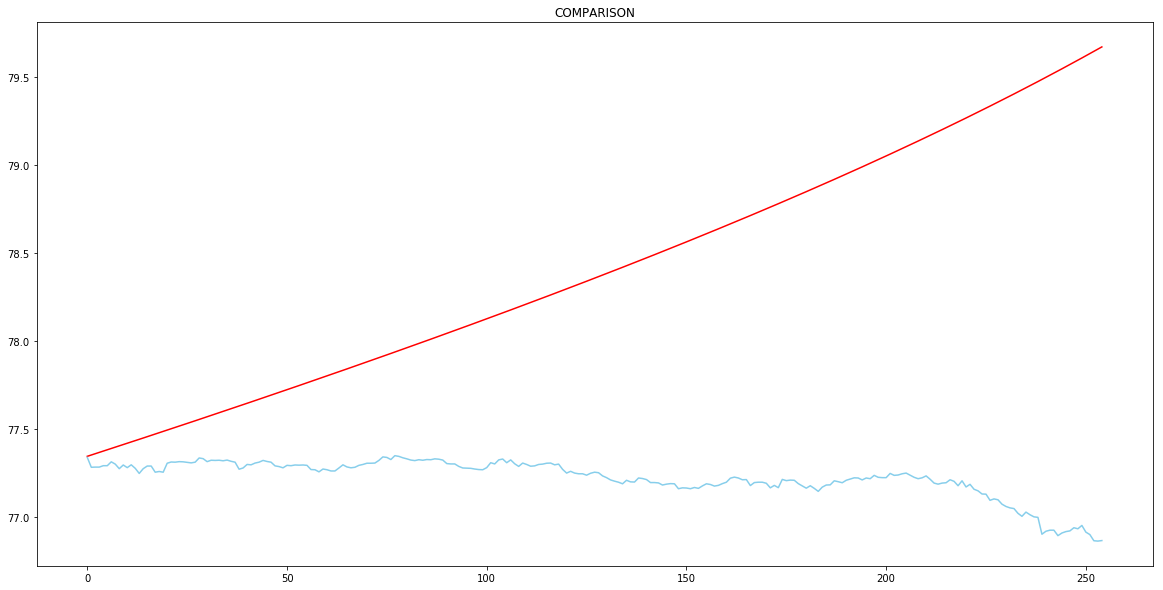

In [24]:
plt.figure(figsize=(20,10))
plt.plot(scaler2.inverse_transform(predict_all_through[:255]), color='red')
plt.plot(testY_df[:255], color='skyblue')
plt.title("COMPARISON")
plt.show()